# Implementar versiones estocásticas de algoritmos de descenso de gradiente 

**Yamil Ernesto Morfa Avalos**

En este trabajo se  implementaran algunas versiones del algoritmos de descenso de gradiente estocásticas para resolver el problema:

$$ \min F\left( \alpha, \mu \right) = \frac{1}{2}\| \Phi\alpha - y \|_{2}^{2}$$

donde $\Phi\in\mathbb{R}^{n\times m}$ $$\Phi = \left[\Phi_{1}, \, \Phi_{2},\, ...,\, \Phi_{n}\right]$$

con $$\Phi_{ij} = \exp\left(-\frac{1}{2\sigma^{2}}\left(j - \mu_{i}\right)^{2}\right)$$



$y \in \mathbb{R}^{n\times 1}$: es un vector de dimensión $n$ que representa los valores de la serie de tiempo;

$\alpha \in \mathbb{R}^{m\times 1}$: es un vector de coeficientes de dimensión $m$ cuyas entradas representan la contribución de cada una de las $j$-ésimas funciones base $\Phi_j$ para aproximar óptimamente $y$;

$\sigma$:  es una constante que determina el ancho de cada fucnión base.



Comensemos por construir una serie de tiempo $\left(y_{i}\right)_{0\leq i\leq n};\,\, y_{i}\in\mathbb{R}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit

n = 1000 ## tamaño 
m = 15 ## dimensión 
sigma = 0.5
index = np.linspace(0, 5*np.pi, n)
Y = (index)*np.sin(index) + np.random.normal(loc=0, scale=sigma, size=n)
Y = Y.reshape(-1,1)

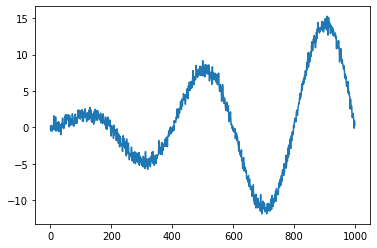

In [2]:
plt.plot(Y)
plt.show()

Los parámetros de interés son $\alpha$ y $\mu$. Calemos el gradiente.

$$\frac{\partial F}{\partial \alpha} = \frac{1}{2}\frac{\partial}{\partial \alpha}\{\left( \Phi\alpha - y\right)^{T}\left( \Phi\alpha - y\right)\} = \left( \Phi\alpha - y\right)^{T}\Phi $$

$$\nabla F =  \left(\frac{\partial F}{\partial \alpha}\right)^{T} = \Phi^{T} \left( \Phi\alpha - y\right)$$

In [3]:
@jit()
def Phi_i(j, mu_i):
  coef = -(1/(2*sigma**2))
  aux = (j - mu_i)**2
  return np.exp(coef * aux)

@jit()
def Phi(theta):
  alpha = theta[0]
  mu = theta[1]
  n = mu.shape[0]
  m = alpha.shape[0]
  phi = np.empty((n,m))
  for i in range(n):
    for j in range(m):
      phi[i,j] = Phi_i(j, mu[i])
  return phi

@jit()
def F(theta, Y):
  alpha = theta[0]
  phi = Phi(theta)
  aux = phi @ alpha - Y
  return (1/2) * np.linalg.norm(aux)**2 

@jit()
def grad_alpha(theta, Y):
  alpha = theta[0]
  phi = Phi(theta)
  return phi.T @ ((phi @ alpha)  - Y)

In [5]:
### Probando
mu = np.random.rand(n,1)
print('Shape de mu: ', mu.shape)
alpha = np.random.rand(m,1)
print('Shape  de alpha', alpha.shape)
phi = Phi([alpha, mu])
print('Shape de Phi', phi.shape)
g_alpha = grad_alpha([alpha, mu], Y)
print('Shape de Gradiente de alpha', g_alpha.shape)

Shape de mu:  (1000, 1)
Shape  de alpha (15, 1)
Shape de Phi (1000, 15)
Shape de Gradiente de alpha (15, 1)


Análogamente calculemos el gradiente de con respecto a $\mu$

$$\frac{\partial F}{\partial \mu_{i}} =\frac{1}{2}  \frac{\partial F}{\partial \mu_{i}} \sum_{i=1}^{n}\left( \sum_{j=1}^{m} \phi_{ij}\alpha_{j}  - y_{i}\right)^{2} = \left( \sum_{j=1}^{m} \phi_{ij}\alpha_{j}  - y_{i}\right) \frac{\partial }{\partial \mu_{i}}\left( \sum_{j=1}^{m} \phi_{ij}\alpha_{j} \right) =$$

$$= \left( \sum_{j=1}^{m} \phi_{ij}\alpha_{j}  - y_{i}\right) \sum_{j=1}^{m}\left\{\alpha_{j}\exp\left(-\frac{1}{2\sigma^{2}}\left(j - \mu_{i}\right)^{2}\right)\left[ \frac{1}{\sigma^{2}}\left(j - \mu_i\right) \right]
\right\}$$



In [6]:
@jit
def grad_mu(theta, Y):
  alpha = theta[0]
  mu = theta[1]
  n = mu.shape[0]
  m = alpha.shape[0]
  g_mu = np.empty_like(mu)
  coef = -(1/(2*sigma**2))
  phi = Phi(theta)
  for i in range(n):
    aux1 = phi[i,:] @ alpha - Y[i]
    j = np.arange(m)
    diff = j.reshape(-1,1) - mu[i]
    aux2 = alpha*np.exp( coef*diff**2 ) * (-2*coef) * diff
    g_mu[i] = aux1 * (aux2.sum())
  return g_mu

In [8]:
print('Shape del gradiente de mu: ', grad_mu([alpha, mu],  Y).shape)

Shape del gradiente de mu:  (1000, 1)


Tenemos las expreciones de los gradientes para $\alpha$ y $\mu$. Primero impelmentemos las verciones no estacásticas de los metodos GD, NAG, ADADELTA, NADAM. 

## Implementación de Descenso del Gradiente

Para el problema de optimización:
$$\arg\min_{\theta} F\left(\theta\right)$$
decimos que $p$ es una direccion de descenso si se cumple que: $$ p^T\nabla F\left(\theta\right) < 0 $$
Además se puede demostrar que:
$$F\left(\theta - \lambda p\right) < F\left(\theta\right)$$
Luego se puede demostrar que $p  = -\nabla F\left(\theta\right)$ es la máxima direccion de descenso.


Entonces la idea es dar pasos repetidos en la dirección opuesta al gradiente (o una aproximación del gradiente) de la función, con el fin de encontrar el argumento minimo $\theta$ de $F$. Esto es de la forma:

$$\theta_{n+1} = \theta_{n} - \lambda\nabla F\left(\theta_{n}\right)$$

donde $\theta_{n}$ representa el prámetro en la posición $n$ dado un parámetro inicial $\theta_{1}$; $F$ representa la función de costo y $\lambda$ una tamaño de paro o learning rate. 

In [9]:
### Descenso del Gradiente Usual

@jit
def GD(theta, gd_params, Y, grad ,loss_f ):
  '''
    Descenso de gradiente
    
    Parámetros
    -----------

    theta     :   parámetro inicial
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter = gd_params['nIter'] número de iteraciones
                      lr = gd_params['lr'] tamaño de paso 
                      tol = gd_params['tol'] tolerancia
    Y         :   valores de la serie de tiempo
    grad      : funcion que calcula el gradiente
    loss_f    : Función de costo 

    Regresa
    -----------
    Alpha     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
  

  nIter = gd_params['nIter']
  lr    = gd_params['lr']
  tol   = gd_params['tol']
  Theta = []
  loss = []
  for t in range(nIter):
    theta0 = theta
    theta = theta - lr*grad(theta, Y)
    Theta.append(theta)
    var_dom = np.linalg.norm(theta0- theta)
    var_img = abs(loss_f(theta0, Y) - loss_f(theta, Y))
    loss.append([var_dom, var_img])
    if  var_dom and var_img  <= tol:
      break
  return np.array(Theta), np.array(loss)

Con el fin de probar el funcionamiento de GD, fijemos un parámetro y veamos como se comporta el método.

In [11]:
grad_a = lambda parm, Y: grad_alpha([parm, mu], Y)
loss_f_a = lambda parm, Y: F([parm, mu], Y)

grad_m = lambda parm, Y: grad_mu([alpha, parm], Y)
loss_f_m = lambda parm, Y: F([alpha, parm], Y)

Alpha, loss_a = GD(alpha, {'nIter':50, 'lr':1e-3, 'tol':1e-5}, Y, grad_a, loss_f_a)
MU, loss_m = GD(mu, {'nIter':50, 'lr':1e-3, 'tol':1e-5}, Y, grad_m, loss_f_m)


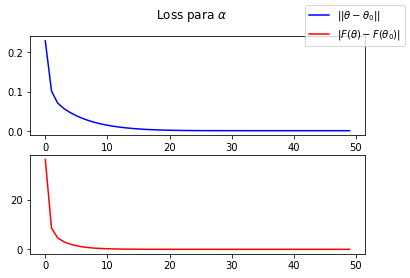

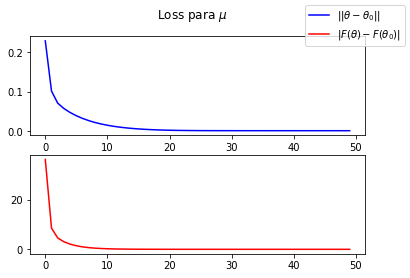

In [12]:
def get_loss_plot(loss, theta):
  fig, aex = plt.subplots(2)
  fig.suptitle(r'Loss para $\{}$'.format(theta))
  aex[0].plot(loss_a[:,0], 'blue',label = r'$\|| \theta - \theta_{0} \||$')
  aex[1].plot(loss_a[:,1], 'red',label = r'$\| F\left(\theta\right) -F\left(\theta_{0}\right) \|$')
  fig.legend()
  plt.show()

get_loss_plot(loss_a, 'alpha')
get_loss_plot(loss_m, 'mu')


## Implementación de Descenso acelerado de Nesterov



In [13]:
@jit
def NAG(theta, gd_params, Y, grad ,loss_f):
    '''
    Descenso acelerado de Nesterov
    
    Parámetros
    -----------
    theta     :   condicion inicial
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter = gd_params['nIter'] número de iteraciones
                      lr = gd_params['lr'] tamaño de paso alpha
                      eta   = gd_params['eta']  parametro de inercia (0,1]
                      tol   = gd_params['tol']  tolerancia
    grad      : funcion que calcula el gradiente
    loss_f    : Función de costo 

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''

    nIter  = gd_params['nIter']
    lr     = gd_params['lr'] 
    eta    = gd_params['eta']
    Theta  =[]
    tol    = gd_params['tol']
    p      = np.zeros(theta.shape)
    
    loss = []
    for t in range(nIter):
      theta0 = theta      
      pre_theta = theta - 2.0*lr*p
      g = grad(pre_theta, Y)
      p = g + eta*p
      theta = theta - lr*p
      
      ## loss
      Theta.append(theta)
      var_dom = np.linalg.norm(theta0- theta)
      var_img = abs( loss_f(theta, Y) - loss_f(theta0, Y))
      loss.append([var_dom, var_img])
      if var_img <= tol:
        break

    return np.array(Theta), np.array(loss)

In [15]:
Alpha, loss_a = NAG(alpha, {'nIter':50, 'lr':1e-3, 'tol':1e-5, 'eta':0.5}, Y, grad_a, loss_f_a)
MU, loss_m = NAG(mu, {'nIter':50, 'lr':1e-3, 'tol':1e-5, 'eta':0.5}, Y, grad_m, loss_f_m)

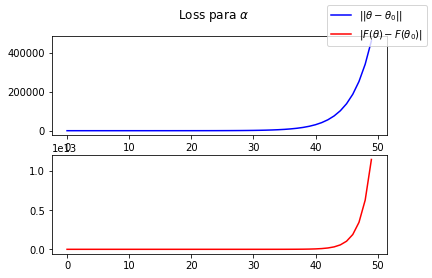

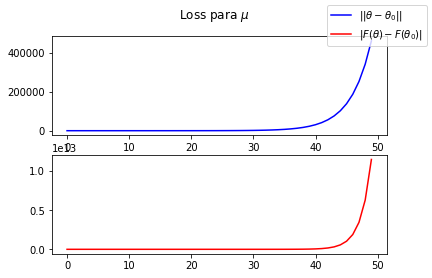

In [12]:
get_loss_plot(loss_a, 'alpha')
get_loss_plot(loss_m, 'mu')

## Implementación de Descenso de Gradiente Adaptable (ADADELTA)

In [16]:
@jit
def ADADELTA(theta, gd_params, Y, grad ,loss_f):
    '''
    Descenso de Gradiente Adaptable (ADADELTA) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      lr = gd_params['lr_ADADELTA'] tamaño de paso a
                      eta      = gd_params['eta']  parametro adaptación del paso 
                      tol   = gd_params['tol']  tolerancia          

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    epsilon= 1e-8
    nIter = gd_params['nIter']
    lr    = gd_params['lr_ADADELTA'] 
    eta   = gd_params['eta']
    G  = np.zeros(theta.shape)
    g  = np.zeros(theta.shape) 
    tol = gd_params['tol']
    Theta=[]
    loss = []
    for t in range(nIter):
      theta0 = theta
      g = grad(theta, Y)
      G = eta*g**2 + (1-eta)*G
      p = 1.0/(np.sqrt(G)+epsilon)*g
      theta = theta - lr * p
      Theta.append(theta)
      ## loss
      var_dom = np.linalg.norm(theta0- theta)
      var_img = abs( loss_f(theta, Y) - loss_f(theta0, Y))
      loss.append([var_dom, var_img])
      if var_img <= tol:
        break
    return np.array(Theta), np.array(loss)

In [18]:
Alpha, loss_a = ADADELTA(alpha, {'nIter':50, 'lr_ADADELTA':1e-3, 'tol':1e-5, 'eta':0.5}, Y, grad_a, loss_f_a)
MU, loss_m = ADADELTA(mu, {'nIter':50, 'lr_ADADELTA':1e-3, 'tol':1e-5, 'eta':0.5}, Y, grad_m, loss_f_m)

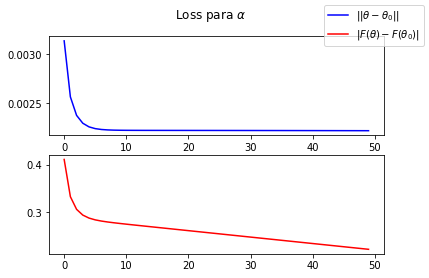

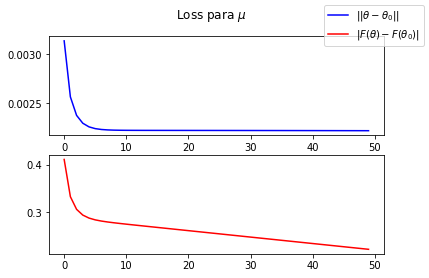

In [19]:
get_loss_plot(loss_a, 'alpha')
get_loss_plot(loss_m, 'mu')

## Implementación de Momentum Adaptable (ADAM)

In [20]:
@jit
def ADAM(theta, gd_params, Y, grad ,loss_f):
    '''
    Descenso de Gradiente Adaptable con Momentum(A DAM) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      lr = gd_params['lr_ADAM'] tamaño de paso alpha
                      eta1     = gd_params['eta1'] factor de momentum para la direccion 
                                 de descenso (0,1)
                      eta2     = gd_params['eta2'] factor de momentum para la el 
                                 tamaño de paso (0,1)               

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    lr       = gd_params['lr_ADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    tol      = gd_params['tol']
    p        = np.zeros(theta.shape)
    v        = 0.0
    Theta    = []
    loss = []
    eta1_t = eta1
    eta2_t = eta2
    for t in range(nIter):
        theta0 = theta
        g  = grad(theta, Y)
        p  = eta1*p + (1.0-eta1)*g
        v  = eta2*v + (1.0-eta2)*(g**2)
        p = p/(1.-eta1_t)
        v = v/(1.-eta2_t)

        theta = theta - lr * p / (np.sqrt(v)+epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        Theta.append(theta)
        ## loss
      
        var_dom = np.linalg.norm(theta0- theta)
        var_img = abs( loss_f(theta, Y) - loss_f(theta0, Y))
        loss.append([var_dom, var_img])
        if var_img <= tol:
          break
    return np.array(Theta), np.array(loss)

In [22]:
Alpha, loss_a = ADAM(alpha, {'nIter':50, 'lr_ADAM':1e-3, 'tol':1e-5, 'eta1':0.5, 'eta2':0.5}, Y, grad_a, loss_f_a)
MU, loss_m = ADAM(mu, {'nIter':50, 'lr_ADAM':1e-3, 'tol':1e-5, 'eta1':0.5, 'eta2':0.5}, Y, grad_m, loss_f_m)

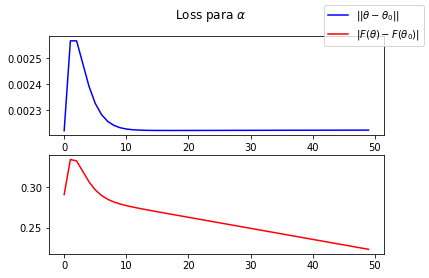

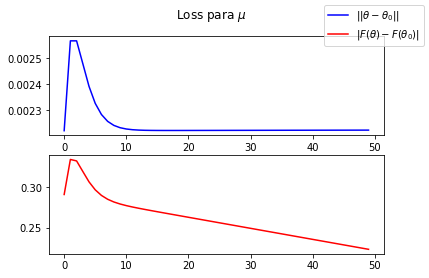

In [23]:
get_loss_plot(loss_a, 'alpha')
get_loss_plot(loss_m, 'mu')

## Implementación de Nesterov-accelerated Adaptive Moment Estimation (NADAM)

In [24]:
@jit
def NADAM(theta, gd_params, Y, grad ,loss_f):
    '''
    Descenso de Gradiente  Nesterov-accelerate Adaptable con Momentum(NADAM) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      lr = gd_params['lr_ADAM'] tamaño de paso alpha
                      eta1     = gd_params['eta1'] factor de momentum para la direccion 
                                 de descenso (0,1)
                      eta2     = gd_params['eta2'] factor de momentum para la el 
                                 tamaño de paso (0,1)               

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    lr       = gd_params['lr_ADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    tol      = gd_params['tol']
    p        = np.zeros(theta.shape)
    v        = 0.0
    Theta    = []
    loss = []
    eta1_t = eta1
    eta2_t = eta2
    for t in range(nIter):
        theta0 = theta
        g  = grad(theta, Y)
        p  = eta1*p + (1.0-eta1)*g
        v  = eta2*v + (1.0-eta2)*(g**2)
        
        ### corrección
        p = p/(1.-eta1_t)
        v = v/(1.-eta2_t)

        ### nesterov
        nag_g = eta1*p + ((1-eta1) * g)/(1 - eta1_t)


        theta = theta - lr * nag_g / (np.sqrt(v)+epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        Theta.append(theta)
        ## loss
      
        var_dom = np.linalg.norm(theta0- theta)
        var_img = abs( loss_f(theta, Y) - loss_f(theta0, Y))
        loss.append([var_dom, var_img])
        if var_img <= tol:
          break
    return np.array(Theta), np.array(loss)

In [26]:
Alpha, loss_a = NADAM(alpha, {'nIter':50, 'lr_ADAM':1e-3, 'tol':1e-5, 'eta1':0.5, 'eta2':0.5}, Y, grad_a, loss_f_a)
MU, loss_m = NADAM(mu, {'nIter':50, 'lr_ADAM':1e-3, 'tol':1e-5, 'eta1':0.5, 'eta2':0.5}, Y, grad_m, loss_f_m)

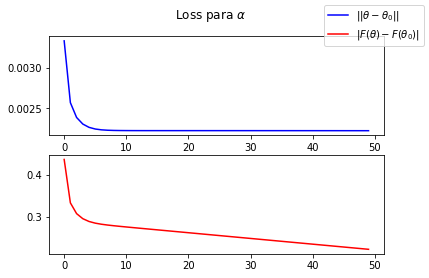

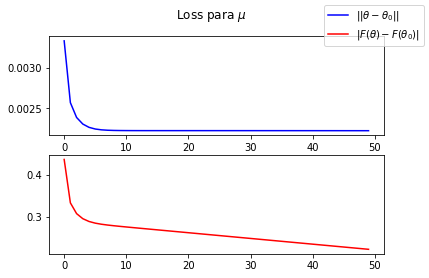

In [27]:
get_loss_plot(loss_a, 'alpha')
get_loss_plot(loss_m, 'mu')

In [28]:

def get_argmin(alpha, mu, Y, method, param, gd_params):
  grad_a = lambda parm, Y: grad_alpha([parm, mu], Y)
  loss_f_a = lambda parm, Y: F([parm, mu], Y)

  grad_m = lambda parm, Y: grad_mu([alpha, parm], Y)
  loss_f_m = lambda parm, Y: F([alpha, parm], Y)

  if method == 'GD':
    if param == 'alpha':
      Alpha, loss_a = GD(alpha, gd_params, Y, grad_a, loss_f_a)
      return Alpha[-1]
    elif param == 'mu':
      MU, loss_m = GD(mu, gd_params, Y, grad_m, loss_f_m)
      return MU[-1]
    else:
      print('Parámetro incorrecto')
  elif method == 'NAG':
    if param == 'alpha':
      Alpha, loss_a = NAG(alpha, gd_params, Y, grad_a, loss_f_a)
      return Alpha[-1]
    elif param == 'mu':
      MU, loss_m = NAG(mu, gd_params, Y, grad_m, loss_f_m)
      return MU[-1]
    else:
      print('Parámetro incorrecto')
  elif method == 'ADADELTA':
    if param == 'alpha':
      Alpha, loss_a = ADADELTA(alpha, gd_params, Y, grad_a, loss_f_a)
      return Alpha[-1]
    elif param == 'mu':
      MU, loss_m = ADADELTA(mu, gd_params, Y, grad_m, loss_f_m)
      return MU[-1]
    else:
      print('Parámetro incorrecto') 
  elif method == 'ADAM':
    if param == 'alpha':
      Alpha, loss_a = ADAM(alpha, gd_params, Y, grad_a, loss_f_a)
      return Alpha[-1]
    elif param == 'mu':
      MU, loss_m = ADAM(mu, gd_params, Y, grad_m, loss_f_m)
      return MU[-1]
    else:
      print('Parámetro incorrecto')  
  elif method == 'NADAM':
    if param == 'alpha':
      Alpha, loss_a = NADAM(alpha, gd_params, Y, grad_a, loss_f_a)
      return Alpha[-1]
    elif param == 'mu':
      MU, loss_m = NADAM(mu, gd_params, Y, grad_m, loss_f_m)
      return MU[-1]
    else:
      print('Parámetro incorrecto') 
  else:
    print('Método incorrecto')

In [29]:
gd_params = {'lr'          : 1e-3, 
             'lr_ADADELTA' : 1e-3,
             'lr_ADAM'     : 1e-3,
             'nIter'       : 100,
             'batch_size'  : 100,
             'eta'         : 0.9,
             'eta1'        : 0.9,
             'eta2'        : 0.999,
             'tol'         : 1e-5}

get_argmin(alpha, mu, Y, 'GD', 'alpha', gd_params)

array([[ 0.94630656],
       [ 0.71697909],
       [-0.21437057],
       [ 0.10886957],
       [ 0.89817623],
       [ 0.49157078],
       [ 0.64572821],
       [ 0.68963676],
       [ 0.20193678],
       [ 0.47294937],
       [ 0.8166967 ],
       [ 0.579313  ],
       [ 0.14899776],
       [ 0.24894872],
       [ 0.02546316]])

Ahora implementemos la versión estocastica de estos algortimos.

In [30]:
@jit
def stocastic(theta, Y, get_argmin, method, gd_params ):
    '''
    Version estocástica
    '''

    batch_size = gd_params['batch_size']
    n = Y.shape[0]
    nIter      = gd_params['nIter']
    tol        = gd_params['tol']
    Theta=[]
    loss = []
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=n, size=batch_size, dtype='int32')
        
        # sample 
        y = Y[smpIdx]
        # parametros
        alpha = theta[0]
        mu = theta[1]

        ## arg min de alpha
        theta[0] = get_argmin(alpha, mu[smpIdx], y, method, 'alpha' ,gd_params)
        
        ## arg min de mu
        theta[1][smpIdx] = get_argmin(theta[0], mu[smpIdx], y, method, 'mu' ,gd_params)
        
        Theta.append(theta)
        var_img = abs( F(theta, Y) - F([alpha, mu], Y))
        if (t+1)%10 ==0:
          print('> iter {}/{} loss: {:.3e}'.format(t+1, nIter, var_img))
        loss.append(var_img)
        if var_img <= tol:
          print('convergencia')
          break
    
    return Theta, loss

## Evaluación del los algoritmos

In [32]:
gd_params = {'lr'          : 1e-3, 
             'lr_ADADELTA' : 1e-3,
             'lr_ADAM'     : 1e-3,
             'nIter'       : 100,
             'batch_size'  : 100,
             'eta'         : 0.9,
             'eta1'        : 0.9,
             'eta2'        : 0.999,
             'tol'         : 1e-5}
from time import time
theta = [alpha, mu]

t0 = time()
Theta_gd, loss_gd = stocastic(theta, Y, get_argmin, 'GD', gd_params)
print('Tiempo de ejecución de GD: ', time()-t0)

> iter 10/100 loss: 1.990e+02
> iter 20/100 loss: 3.837e+01
> iter 30/100 loss: 2.043e+01
> iter 40/100 loss: 4.347e+01
> iter 50/100 loss: 8.295e+00
> iter 60/100 loss: 8.337e+00
> iter 70/100 loss: 3.968e-01
> iter 80/100 loss: 5.807e-01
> iter 90/100 loss: 1.375e+00
> iter 100/100 loss: 2.182e-01
Tiempo de ejecución de GD:  151.4581971168518


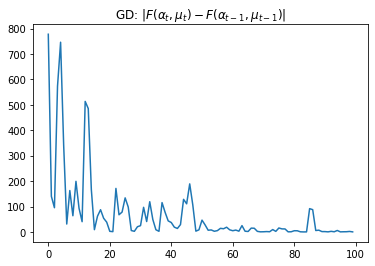

In [33]:
plt.plot(loss_gd)
plt.title(r'GD: $\| F\left(\alpha_{t}, \mu_{t} \right) - F\left(\alpha_{t-1}, \mu_{t-1} \right) \|$')
plt.show()

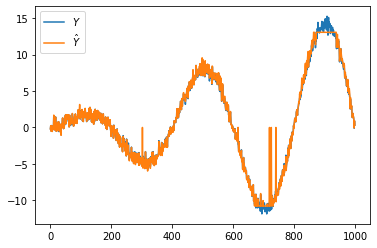

In [34]:
def plot_pred(theta, Y):
  phi = Phi(theta)
  Y_pred = phi @ theta[0]
  plt.plot(Y, label = r'$Y$')
  plt.plot(Y_pred, label = r'$\hat{Y}$')
  plt.legend()
  plt.show()

plot_pred(Theta_gd[-1], Y)

In [35]:
t0 = time()
Theta_nag, loss_nag = stocastic(theta, Y, get_argmin, 'NAG', gd_params)
print('Tiempo de ejecución de NAG: ', time()-t0)

> iter 10/100 loss: 4.612e+00
> iter 20/100 loss: 4.520e+00
> iter 30/100 loss: 4.033e-01
> iter 40/100 loss: 2.736e-01
> iter 50/100 loss: 8.177e-01
> iter 60/100 loss: 1.391e-01
> iter 70/100 loss: 6.822e-01
> iter 80/100 loss: 8.850e-02
> iter 90/100 loss: 7.986e-02
> iter 100/100 loss: 8.655e-01
Tiempo de ejecución de NAG:  92.47157549858093


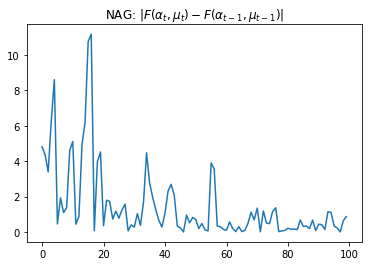

In [36]:
plt.plot(loss_nag)
plt.title(r'NAG: $\| F\left(\alpha_{t}, \mu_{t} \right) - F\left(\alpha_{t-1}, \mu_{t-1} \right) \|$')
plt.show()

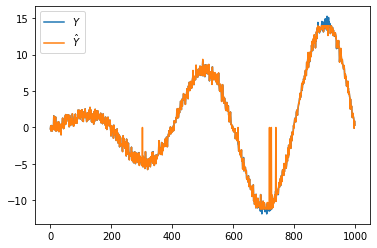

In [37]:
plot_pred(Theta_nag[-1], Y)

In [38]:
t0 = time()
Theta_adadelta, loss_adadelta = stocastic(theta, Y, get_argmin, 'ADADELTA', gd_params)
print('Tiempo de ejecución de ADADELTA: ', time()-t0)

> iter 10/100 loss: 1.009e-01
> iter 20/100 loss: 4.748e-02
> iter 30/100 loss: 3.100e-01
> iter 40/100 loss: 8.018e-02
> iter 50/100 loss: 1.164e-02
> iter 60/100 loss: 2.250e-01
> iter 70/100 loss: 8.400e-02
> iter 80/100 loss: 1.590e-01
> iter 90/100 loss: 8.739e-02
> iter 100/100 loss: 1.162e-01
Tiempo de ejecución de ADADELTA:  86.65140461921692


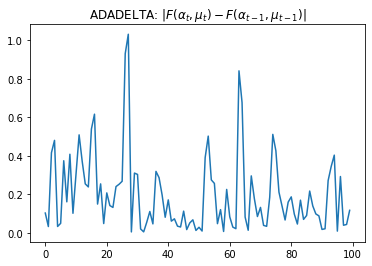

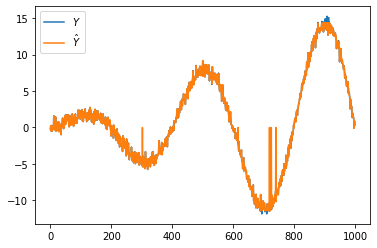

In [39]:
plt.plot(loss_adadelta)
plt.title(r'ADADELTA: $\| F\left(\alpha_{t}, \mu_{t} \right) - F\left(\alpha_{t-1}, \mu_{t-1} \right) \|$')
plt.show()
plot_pred(Theta_adadelta[-1], Y)

In [40]:
t0 = time()
Theta_adam, loss_adam = stocastic(theta, Y, get_argmin, 'ADAM', gd_params)
print('Tiempo de ejecución de ADAM: ', time()-t0)


> iter 10/100 loss: 2.593e-04
> iter 20/100 loss: 3.319e-03
> iter 30/100 loss: 5.682e-03
> iter 40/100 loss: 3.586e-03
> iter 50/100 loss: 1.687e-03
> iter 60/100 loss: 3.332e-03
> iter 70/100 loss: 4.616e-04
> iter 80/100 loss: 2.081e-03
> iter 90/100 loss: 5.848e-03
> iter 100/100 loss: 5.301e-03
Tiempo de ejecución de ADAM:  18.9301540851593


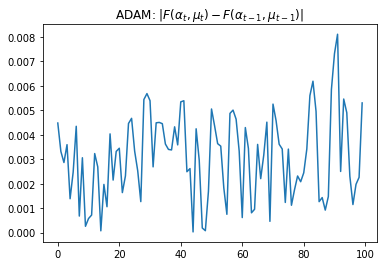

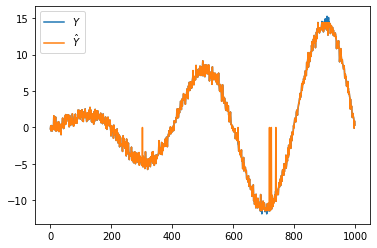

In [41]:
plt.plot(loss_adam)
plt.title(r'ADAM: $\| F\left(\alpha_{t}, \mu_{t} \right) - F\left(\alpha_{t-1}, \mu_{t-1} \right) \|$')
plt.show()
plot_pred(Theta_adam[-1], Y)

In [42]:
t0 = time()
Theta_nadam, loss_nadam = stocastic(theta, Y, get_argmin, 'NADAM', gd_params)
print('Tiempo de ejecución de NADAM: ', time()-t0)

> iter 10/100 loss: 9.688e-03
> iter 20/100 loss: 3.632e-03
> iter 30/100 loss: 4.220e-03
> iter 40/100 loss: 9.773e-03
> iter 50/100 loss: 7.568e-03
> iter 60/100 loss: 6.030e-03
> iter 70/100 loss: 3.925e-04
> iter 80/100 loss: 2.342e-03
> iter 90/100 loss: 3.184e-03
> iter 100/100 loss: 1.594e-03
Tiempo de ejecución de NADAM:  18.9143226146698


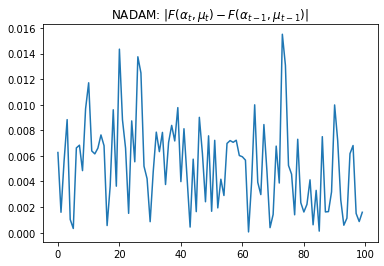

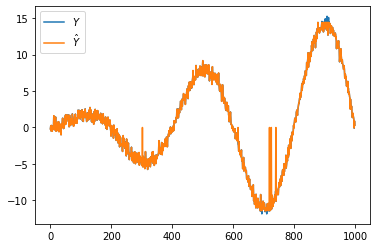

In [43]:
plt.plot(loss_nadam)
plt.title(r'NADAM: $\| F\left(\alpha_{t}, \mu_{t} \right) - F\left(\alpha_{t-1}, \mu_{t-1} \right) \|$')
plt.show()
plot_pred(Theta_nadam[-1], Y)